In [1]:
import glob
import tensorflow as tf
import datetime
import matplotlib.pyplot as plt
import seaborn as sb
import segmentation_models as sm
import functools as ft
import pandas as pd
import numpy as np

sm.set_framework("tf.keras")
sm.framework()

tf.random.set_seed(1024)


2021-10-21 12:55:50.348084: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


Segmentation Models: using `keras` framework.


# Data cleaning process


In [2]:
def get_seagull_path(istrain=True):
    directory = "/home/hackerton/Downloads/Airbus + Seagull Dataset/"

    if istrain:
        trainimg = os.path.join(directory, "trainimg", "*.jpg")
        images = glob.glob(trainimg, recursive=True)
        trainmask = os.path.join(directory, "trainmask", "*.jpg")
        labels = glob.glob(trainmask, recursive=True)
    else:
        testimg = os.path.join(directory, "testimg", "*.jpg")
        images = glob.glob(testimg, recursive=True)
        testmask = os.path.join(directory, "testmask", "*.jpg")
        labels = glob.glob(testmask, recursive=True)

    print(len(images), len(labels))

    mask_set = set()
    image_set = set()
    for lbl in labels:
        lbl = lbl.split("/")[-1]
        mask_set.add(lbl)

    for img in images:
        img = img.split("/")[-1]
        image_set.add(img)

    complete_path = mask_set.intersection(image_set)
    print(
        f"IMG - LBL NUM: {len(image_set.difference(mask_set))}, Intersection: {len(complete_path)}"
    )

    return [i for i in complete_path]


In [3]:
def get_image_decode(image, label):
    image = tf.io.read_file(image, "image")
    label = tf.io.read_file(label, "label")

    image = tf.image.decode_image(image)
    label = tf.image.decode_image(label)

    return image, label


def path_2_test(path):
    return (
        "/home/hackerton/Downloads/Airbus + Seagull Dataset/testimg/" + path,
        "/home/hackerton/Downloads/Airbus + Seagull Dataset/testmask/" + path,
    )


def path_2_train(path):
    return (
        "/home/hackerton/Downloads/Airbus + Seagull Dataset/trainimg/" + path,
        "/home/hackerton/Downloads/Airbus + Seagull Dataset/trainmask/" + path,
    )


def get_mask(image, label):
    labels = []
    labels.append(label[:, :, 0] == 0)
    labels.append(label[:, :, 0] == 255)

    labels = tf.cast(labels, tf.float32)
    image = tf.cast(image, tf.float32)

    # must perform this
    return image, tf.transpose(labels, [1, 2, 0])


def create_ds(batch_size, ratio=0.8):
    AUTOTUNE = tf.data.AUTOTUNE

    paths = get_seagull_path()
    ds1 = tf.data.Dataset.from_tensor_slices(paths)
    ds1 = ds1.map(path_2_train, AUTOTUNE)

    paths = get_seagull_path(False)
    ds2 = tf.data.Dataset.from_tensor_slices(paths)
    ds2 = ds2.map(path_2_test, AUTOTUNE)

    ds = ds1.concatenate(ds2)
    ds = ds.cache()

    takefortrain = int(23124 * ratio)
    trainds = ds.take(takefortrain)
    testds = ds.skip(takefortrain).take(23124 - takefortrain)

    trainds = trainds.shuffle(23124)

    trainds = trainds.map(get_image_decode, AUTOTUNE)
    trainds = trainds.map(get_mask, AUTOTUNE)
    testds = testds.map(get_image_decode, AUTOTUNE)
    testds = testds.map(get_mask, AUTOTUNE)

    # # batch and prefetch
    trainds = trainds.batch(batch_size)
    testds = testds.batch(batch_size)

    trainds = trainds.prefetch(AUTOTUNE)

    return trainds, testds


In [4]:
# sum_background = 0
# sum_ship = 0

# trainds, testds = create_ds(1)

# for _, label in trainds:
#     sum_background += tf.reduce_sum(label[..., 0])
#     sum_ship += tf.reduce_sum(label[..., 1])

# total_sum = sum_background + sum_ship
# print("ratio of weight")
# print(f"BACKGROUND: {sum_background / total_sum}, SHIP: {sum_ship / total_sum}")


In [5]:
# for img, label in trainds.take(2):
#     fig, axs = plt.subplots(1, 2, figsize=(9, 16))
#     axs[0].imshow(tf.cast(img[0], tf.int32))
#     axs[1].imshow(tf.cast(label[0, ..., 0], tf.int32))

In [6]:
# data = create_ds(1, False, True)
# total_mask_sum = tf.zeros([8], tf.int64)
# for image, mask in data:
#     mask = tf.cast(mask, tf.int64)
#     mask_sum = tf.reduce_sum(mask, [0, 1, 2])
#     total_mask_sum += mask_sum


In [7]:
# plt.figure(figsize=(15, 7))
# plt.bar([str(i) for i in range(8)], total_mask_sum / tf.reduce_max(total_mask_sum), color=['blue', 'red', 'green', 'yellow'], align='center', alpha=0.8)
# plt.grid(True)
# plt.title('The number of samples mask in each class')
# (total_mask_sum / tf.reduce_mean(total_mask_sum))


In [8]:
def create_backbone():
    _backbone = tf.keras.applications.EfficientNetB0(
        include_top=False, input_shape=[None, None, 3]
    )

    outputs = [
        layer.output
        for layer in _backbone.layers
        if layer.name
        in [
            "block2a_activation",
            "block3a_activation",
            "block5a_activation",
            "block7a_activation",
        ]
    ]

    return tf.keras.Model(
        inputs=[_backbone.input], outputs=outputs, name="efficientb0_backbone"
    )


class FPN(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(name="Feature_Pyramid_Network", **kwargs)

        self.backbone = create_backbone()
        self.conv5_1x1 = tf.keras.layers.Conv2D(
            filters=256, kernel_size=(1, 1), padding="same"
        )
        self.conv4_1x1 = tf.keras.layers.Conv2D(
            filters=256, kernel_size=(1, 1), padding="same"
        )
        self.conv3_1x1 = tf.keras.layers.Conv2D(
            filters=256, kernel_size=(1, 1), padding="same"
        )
        self.conv2_1x1 = tf.keras.layers.Conv2D(
            filters=256, kernel_size=(1, 1), padding="same"
        )
        self.conv5_3x3_1 = tf.keras.layers.Conv2D(
            filters=128, kernel_size=(3, 3), padding="same", activation="relu"
        )
        self.conv5_3x3_2 = tf.keras.layers.Conv2D(
            filters=128, kernel_size=(3, 3), padding="same", activation="relu"
        )
        self.conv5_bn = tf.keras.layers.BatchNormalization()
        self.conv4_3x3_1 = tf.keras.layers.Conv2D(
            filters=128, kernel_size=(3, 3), padding="same", activation="relu"
        )
        self.conv4_3x3_2 = tf.keras.layers.Conv2D(
            filters=128, kernel_size=(3, 3), padding="same", activation="relu"
        )
        self.conv4_bn = tf.keras.layers.BatchNormalization()
        self.conv3_3x3_1 = tf.keras.layers.Conv2D(
            filters=128, kernel_size=(3, 3), padding="same", activation="relu"
        )
        self.conv3_3x3_2 = tf.keras.layers.Conv2D(
            filters=128, kernel_size=(3, 3), padding="same", activation="relu"
        )
        self.conv3_bn = tf.keras.layers.BatchNormalization()
        self.conv2_3x3_1 = tf.keras.layers.Conv2D(
            filters=128, kernel_size=(3, 3), padding="same", activation="relu"
        )
        self.conv2_3x3_2 = tf.keras.layers.Conv2D(
            filters=128, kernel_size=(3, 3), padding="same", activation="relu"
        )
        self.conv2_bn = tf.keras.layers.BatchNormalization()
        self.upscale = tf.keras.layers.UpSampling2D(size=(2, 2))

    def call(self, images, training=False):
        # 112x112, 56x56, 28x28, 14x14
        conv2, conv3, conv4, conv5 = self.backbone(images, training=training)
        conv5_m = self.conv5_1x1(conv5)
        conv5_p = self.conv5_3x3_1(conv5_m)
        conv5_p = self.conv5_3x3_2(conv5_p)
        conv5_p = self.conv5_bn(conv5_p, training=training)

        conv4_m_1 = self.upscale(conv5_m)
        conv4_m_2 = self.conv4_1x1(conv4)
        conv4_m = conv4_m_1 + conv4_m_2
        conv4_p = self.conv4_3x3_1(conv4_m)
        conv4_p = self.conv4_3x3_2(conv4_p)
        conv4_p = self.conv4_bn(conv4_p, training=training)

        conv3_m_1 = self.upscale(conv4_m)
        conv3_m_2 = self.conv3_1x1(conv3)
        conv3_m = conv3_m_1 + conv3_m_2
        conv3_p = self.conv3_3x3_1(conv3_m)
        conv3_p = self.conv3_3x3_2(conv3_p)
        conv3_p = self.conv3_bn(conv3_p, training=training)

        conv2_m_1 = self.upscale(conv3_m)
        conv2_m_2 = self.conv2_1x1(conv2)
        conv2_m = conv2_m_1 + conv2_m_2
        conv2_p = self.conv2_3x3_1(conv2_m)
        conv2_p = self.conv2_3x3_2(conv2_p)
        conv2_p = self.conv2_bn(conv2_p, training=training)
        return conv5_p, conv4_p, conv3_p, conv2_p


class FCN(tf.keras.Model):
    def __init__(self, n_classes=8, **kwargs):
        super().__init__(name="FCN", **kwargs)
        self.fpn = FPN()
        self.upscale_2x = tf.keras.layers.UpSampling2D()
        self.upscale_4x = tf.keras.layers.UpSampling2D((4, 4))
        self.upscale_8x = tf.keras.layers.UpSampling2D((8, 8))
        self.concat = tf.keras.layers.Concatenate()
        self.conv6 = tf.keras.layers.Conv2D(
            filters=(512), kernel_size=(3, 3), padding="same", activation="relu"
        )
        self.bnorm = tf.keras.layers.BatchNormalization()
        self.conv7 = tf.keras.layers.Conv2D(
            filters=n_classes, kernel_size=(1, 1), padding="same", activation="relu"
        )
        self.upscale_final = tf.keras.layers.UpSampling2D(
            size=(4, 4), interpolation="bilinear"
        )
        self.final_activation = tf.keras.layers.Activation("softmax")

    def call(self, images, training=False):
        conv5_p, conv4_p, conv3_p, conv2_p = self.fpn(images, training=training)
        m_5 = self.upscale_8x(conv5_p)
        m_4 = self.upscale_4x(conv4_p)
        m_3 = self.upscale_2x(conv3_p)
        m_2 = conv2_p

        m_all = self.concat([m_2, m_3, m_4, m_5])
        m_all = self.conv6(m_all)
        m_all = self.bnorm(m_all, training=training)
        m_all = self.conv7(m_all)
        m_all = self.upscale_final(m_all)
        m_all = self.final_activation(m_all)

        return m_all


class FCN_ORIG(tf.keras.Model):
    def __init__(self, n_classes=8, **kwargs):
        super().__init__(name="FCN_ORIG", **kwargs)

        self.backbone = create_backbone()
        self.conv1 = tf.keras.layers.Conv2D(
            filters=(n_classes), kernel_size=(1, 1), padding="same", activation="relu"
        )
        self.conv2 = tf.keras.layers.Conv2D(
            filters=(n_classes), kernel_size=(1, 1), padding="same", activation="relu"
        )
        self.conv3 = tf.keras.layers.Conv2D(
            filters=(n_classes), kernel_size=(1, 1), padding="same", activation="relu"
        )
        self.upscale2x_1 = tf.keras.layers.Convolution2DTranspose(
            filters=8,
            kernel_size=(4, 4),
            strides=(2, 2),
            padding="same",
            activation="relu",
        )
        self.upscale2x_2 = tf.keras.layers.Convolution2DTranspose(
            filters=8,
            kernel_size=(4, 4),
            strides=(2, 2),
            padding="same",
            activation="relu",
        )
        self.upscale8x = tf.keras.layers.Convolution2DTranspose(
            filters=8,
            kernel_size=(16, 16),
            strides=(8, 8),
            padding="same",
            activation="relu",
        )
        self.final_activation = tf.keras.layers.Activation("softmax")

    def call(self, images, training=False):
        _, conv1_o, conv2_o, conv3_o = self.backbone(images, training=training)
        conv1_o = self.conv1(conv1_o)
        conv2_o = self.conv2(conv2_o)
        conv3_o = self.conv3(conv3_o)

        fcn_16x = self.upscale2x_1(conv3_o) + conv2_o
        fcn_8x = self.upscale2x_2(fcn_16x) + conv1_o
        final_output = self.upscale8x(fcn_8x)
        final_output = self.final_activation(final_output)
        return final_output


In [9]:
# the network must OUTPUT in logits [-inf, inf]
# make sure input dimension is [B, H, W, C]
def Jindex(target, pred):
    intersection = tf.reduce_sum(target * pred, [0, 1, 2])
    union = tf.reduce_sum(target + pred, [0, 1, 2]) - intersection
    return tf.reduce_mean((intersection + 0.1) / (union + 0.1))


def Dice(target, pred):
    intersection = tf.reduce_sum(2 * pred * target, [0, 1, 2])
    union = tf.reduce_sum(pred + target, [0, 1, 2])
    return tf.reduce_mean((intersection + 0.1) / (union + 0.1))


In [10]:
# this iteration is calculated fom 160 iteration from
# paper
n_epoch = 20
n_classes = 2
batch_size = 4
trainds, testds = create_ds(batch_size)
model = FCN(n_classes)
# model = sm.Unet(backbone_name='resnet50', encoder_weights='imagenet', encoder_freeze=False, activation='softmax', classes=8)
# model = FCN_ORIG(8)


19373 17243
IMG - LBL NUM: 10687, Intersection: 8686


2021-10-21 12:55:52.828552: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-10-21 12:55:54.312079: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-21 12:55:54.312340: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 950M computeCapability: 5.0
coreClock: 0.928GHz coreCount: 5 deviceMemorySize: 1.96GiB deviceMemoryBandwidth: 74.65GiB/s
2021-10-21 12:55:54.312370: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-10-21 12:55:54.314803: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-10-21 12:55:54.314866: I tensorflow/stream_executor/platf

14476 14443
IMG - LBL NUM: 38, Intersection: 14438


In [11]:
optimizer = tf.keras.optimizers.Adam(1e-5)
focal_loss = sm.losses.CategoricalFocalLoss()
dice_loss = sm.losses.DiceLoss(class_weights=[0.001, 0.999])

In [12]:
# model.build([None, 448, 448, 3])

# model.layers[0].backbone.trainable = False
# for layer in model.layers[0].backbone.layers:
#     layer.trainable = False
#     if layer.name == 'block5a_activation':
#         break

# model.compile()
# model.summary()


In [13]:
ckpt = tf.train.Checkpoint(model=model, optimizer=optimizer)
ckptmg = tf.train.CheckpointManager(ckpt, "trained_model/seagull_fcn", 5)
ckptmg.restore_or_initialize()

'trained_model/seagull_fcn/ckpt-20'

2021-10-21 12:56:12.280109: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


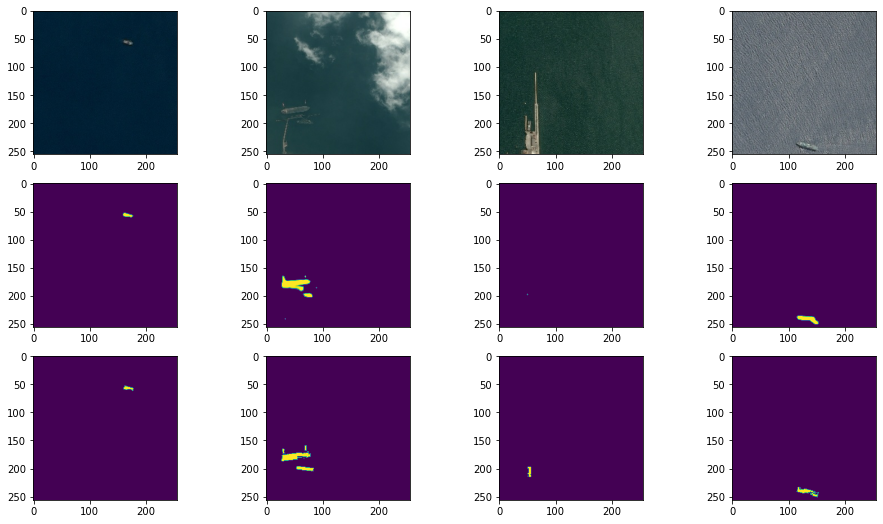

In [16]:
for img, lbl in testds.take(1):
    pred = model(img, training=False)
    pred /= 255.0

    fig, axes = plt.subplots(3, 4, figsize=(16, 9))

    for i in range(4):
        axes[0, i].imshow(img[i] / 255.0)

    for i in range(4):
        axes[1, i].imshow(pred[i, ..., 1])

    for i in range(4):
        axes[2, i].imshow(lbl[i, ..., 1])
